<a href="https://colab.research.google.com/github/dearsanshui/data_exploration/blob/main/Chest_X_Ray_Classification_(Pneumonia_Normal)_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to build a CNN to classify X-ray images into Pheumonia/Normal. The data is provided by [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).<br>

Table of contents:
*   Exploratory Data Analysis
*   Model Build - Transfer Learning
*   Learning Rate Selection
*   Model Training
*   Model Evaluation
*   Summary
*   References



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


We will download dataset from Kaggle and store in Google Drive. This step is not necessary, as you could download the dataset from Kaggle directly into colab.

In [ ]:
%cd /content/gdrive/My Drive/kaggle/datasets
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

User cancelled operation
Archive:  chest-xray-pneumonia.zip
caution: filename not matched:  chest-xray-pneumonia


As the dataset is around 2GB, we will copy the dataset from Google Drive to Colab workspace so that it could be a bit faster when the model access the images.

In [ ]:
!cp "/content/gdrive/MyDrive/kaggle/datasets/chest-xray-pneumonia.zip" "/content/"
!unzip -q chest-xray-pneumonia.zip 

In [ ]:
import os
import fnmatch
import random
import numpy as np
import glob
import cv2
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Exploratory Data Analysis

First, let's check if the unzipped images have the same size as the dataset description declares.

In [ ]:
base_dir = os.path.join('/content', 'chest_xray')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

labels = ['NORMAL', 'PNEUMONIA']

def count_pics(path, pic_ext):
  return len(glob.glob("{}/*.{}".format(path, pic_ext)))

train_neg_size = count_pics(os.path.join(train_dir, labels[0]), 'jpeg')
train_pos_size = count_pics(os.path.join(train_dir, labels[1]), 'jpeg')
val_neg_size = count_pics(os.path.join(val_dir, labels[0]), 'jpeg')
val_pos_size = count_pics(os.path.join(val_dir, labels[1]), 'jpeg')
test_neg_size = count_pics(os.path.join(test_dir, labels[0]), 'jpeg')
test_pos_size = count_pics(os.path.join(test_dir, labels[1]), 'jpeg')

print("train positive: {}, train negative: {}".format(train_pos_size, train_neg_size))
print("val positive: {}, val negative: {}".format(val_pos_size, val_neg_size))
print("test positive: {}, test negative: {}".format(test_pos_size, test_neg_size))

total_pos_size = train_pos_size + val_pos_size + test_pos_size
total_neg_size = train_neg_size + val_neg_size + test_neg_size
total_size = total_pos_size + total_neg_size
print("total: {}".format(total_size))

train positive: 3875, train negative: 1341
val positive: 8, val negative: 8
test positive: 390, test negative: 234
total: 5856


According to the dataset description, there are 5856 X-ray images, the unzipped dataset is correct. <br>
The data is imbalanced, the number of positive examples(Pneumonia) is larger than negative examples(Normal). <br> 
Let's see the train/validation/test set splits.

In [ ]:
print("train/val/test: {:.3f}/{:.3f}/{:.3f}".format((train_pos_size+train_neg_size)/total_size, \
                                            (val_pos_size+val_neg_size)/total_size, \
                                            (test_pos_size+test_neg_size)/total_size))

train/val/test: 0.891/0.003/0.107


As we can see, the provided split, especially validation set, does not follow any suggested split ratio. There are only 16 images in the validation set, it might not be helpful. Let's see this later.<br>
Next, let's check some X-ray images from training set.

In [ ]:
def select_imgs(path, num, ext):
  """
    Randomly select #num images whose extention are ext
    
    Arguments:
    path -- directory path that holds the images
    num -- number of images to select
    ext -- file extension

    Returns:
    (img_lst, label_lst) -- a tuple which consists of two lists: img_lst contains image object and label_lst contains corresponding image label
  """
  img_lst = list()
  label_lst = list()
  img_paths = random.sample(glob.glob("{}/*.{}".format(path, ext)), num)
  for fp in img_paths:
    img_lst.append(cv2.imread(fp))
    label_lst.append(fp.split('/')[4].strip())
  return (img_lst, label_lst)

In [ ]:
n_img, n_label  = select_imgs(os.path.join(train_dir, labels[0]), 3, 'jpeg')
p_imgs, p_label = select_imgs(os.path.join(train_dir, labels[1]), 3, 'jpeg')
imgs = n_img + p_imgs
labels = n_label + p_label

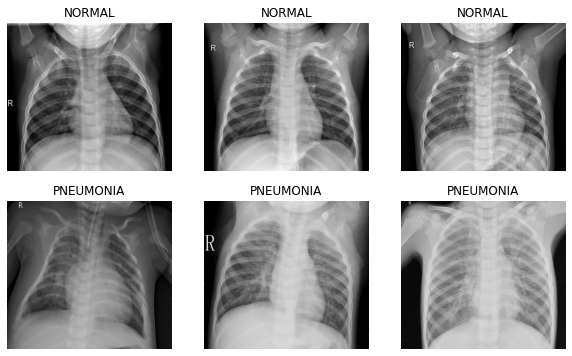

In [ ]:
f, ax = plt.subplots(2, 3, figsize=(10,6))
for i in range(6):
    ax[i//3, i%3].imshow(imgs[i])
    ax[i//3, i%3].set_title(labels[i])
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_aspect('auto')
plt.show()

# Model Creation

Neural Networks are data hungry, since we do not have a large amount of training X-ray images, we are going to use transfer learning in this case. The pre-trained model could help us extract features from X-ray images, then feed those extracted features to a less compcomplicated model for the classification.<br>
In this case, we will use InceptionV3. Let's explore the architecure of InceptionV3

In [ ]:
inception = InceptionV3(include_top=False)
inception.summary()
inception = None

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

InceptionV3 is sure a complex model with many layers, we use the middle layer's output as extracted features to feed our model, since the output of middle layer could be more common features (such as lines, contours) and not very specialized.

In [ ]:
IMG_SHAPE = (180, 180)

In [ ]:
def create_model():
  """
    build the model based on InceptionV3
  """
  base_model = InceptionV3(
      include_top=False, 
      weights="imagenet",
      input_shape= IMG_SHAPE + (3,)
  )
  base_model.trainable = False

  # get the middle layer "mixed6" of InceptionV3 
  last_layer = base_model.get_layer('mixed6')
  last_output = last_layer.output 
  # add a Conv2D layer
  x = Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu')(last_output)
  x = BatchNormalization()(x)
  x = MaxPool2D((2,2), strides = 2, padding = 'same')(x)
  x = Flatten()(x)
  # add a fully connected layer with ReLU activation
  x = Dense(1024, activation='relu')(x)
  # add a dropout rate of 0.2
  x = Dropout(0.2)(x)             
  # add a final sigmoid layer for classification
  x = Dense(1, activation='sigmoid')(x)   
  model = Model(inputs=base_model.input, outputs=x)

  return model

Next, we are going to create training/val/test data with ImageDataGenerators.<br>
ImageDataGenerator allows us to normalize the images and conduct image augementation. Image augementation could help increase diversity in our training set.

In [ ]:
# Add data-augmentation
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
                                  )

val_datagen = ImageDataGenerator(rescale = 1.0/255)
test_datagen = ImageDataGenerator(rescale = 1.0/255)

# Flow training images in batches of 32
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 32,
                                                    class_mode = 'binary',
                                                    target_size = IMG_SHAPE)     

# Flow validation images in batches of 8
val_generator =  val_datagen.flow_from_directory( val_dir,
                                                  batch_size = 8,
                                                  class_mode = 'binary',
                                                  target_size = IMG_SHAPE)

# Flow test images in batches of 32
# The test data will not be shuffled as it will help us easier to get the predicted labels of each image
test_generator =  test_datagen.flow_from_directory( test_dir,
                                                    batch_size = 32,
                                                    class_mode = 'binary',
                                                    target_size = IMG_SHAPE,
                                                    shuffle = False)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)
print(val_generator.class_indices)
print(test_generator.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


# Learning Rate Selection

We will use learning rate decay to find a optimal learning rate, then use it to train our model. 

In [ ]:
tf.keras.backend.clear_session()
model = create_model() 
METRICS = [
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall')
]

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 100**(epoch / 20))
optimizer = tf.keras.optimizers.RMSprop(lr=1e-4)
model.compile(optimizer = optimizer, 
              loss = 'binary_crossentropy', 
              metrics = METRICS)
history = model.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = 163,
            epochs = 10,
            validation_steps = 2,
            verbose = 2,
            callbacks=[lr_schedule])

Epoch 1/10
163/163 - 84s - loss: 0.2353 - accuracy: 0.9099 - precision: 0.9355 - recall: 0.9437 - val_loss: 0.5155 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 2/10
163/163 - 84s - loss: 0.1546 - accuracy: 0.9450 - precision: 0.9631 - recall: 0.9628 - val_loss: 0.1664 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
163/163 - 83s - loss: 0.1243 - accuracy: 0.9548 - precision: 0.9700 - recall: 0.9690 - val_loss: 0.7356 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 4/10
163/163 - 83s - loss: 0.1271 - accuracy: 0.9530 - precision: 0.9675 - recall: 0.9693 - val_loss: 0.2724 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 5/10
163/163 - 84s - loss: 0.1250 - accuracy: 0.9549 - precision: 0.9700 - recall: 0.9693 - val_loss: 0.0273 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 6/10
163/163 - 84s - loss: 0.1290 - accuracy: 0.9530 - precision: 0.9688 - reca

(0.0001, 0.001, 0.0, 0.5)

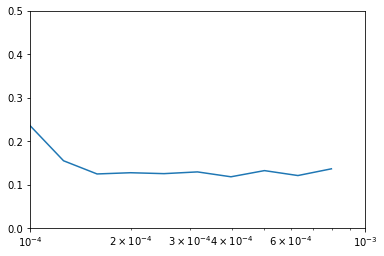

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-3, 0, 0.5])

# Model Training

The loss reached lowest when learning rate is around 0.0003. Thus, we will use this learning rate to retrain our model.

In [ ]:
tf.keras.backend.clear_session()
model = create_model() 
METRICS = [
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall')
]

model.compile(optimizer = RMSprop(lr=0.0003), 
              loss = 'binary_crossentropy', 
              metrics = METRICS)

history = model.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = 163,
            epochs = 10,
            validation_steps = 2,
            verbose = 2)

Epoch 1/10
163/163 - 84s - loss: 0.3199 - accuracy: 0.9057 - precision: 0.9352 - recall: 0.9381 - val_loss: 0.9352 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 2/10
163/163 - 83s - loss: 0.1441 - accuracy: 0.9494 - precision: 0.9662 - recall: 0.9657 - val_loss: 0.3994 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 3/10
163/163 - 83s - loss: 0.1097 - accuracy: 0.9628 - precision: 0.9750 - recall: 0.9750 - val_loss: 0.0665 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/10
163/163 - 82s - loss: 0.1043 - accuracy: 0.9638 - precision: 0.9765 - recall: 0.9747 - val_loss: 0.1314 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 5/10
163/163 - 82s - loss: 0.1001 - accuracy: 0.9670 - precision: 0.9803 - recall: 0.9752 - val_loss: 1.7037 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 6/10
163/163 - 82s - loss: 0.0943 - accuracy: 0.9674 - precision: 0.9781 - reca

In [ ]:
def plot_graphs(history, metrics):
  """
    Paint accuracy and loss line graphs

    Arguments:
    history -- a record of training loss values and metrics values at successive epochs returned by the model
    metric -- the metric to display
  """
  fig, ax = plt.subplots(1, len(metrics), figsize=(20, 3))
  ax = ax.ravel()
  for i, met in enumerate(metrics):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

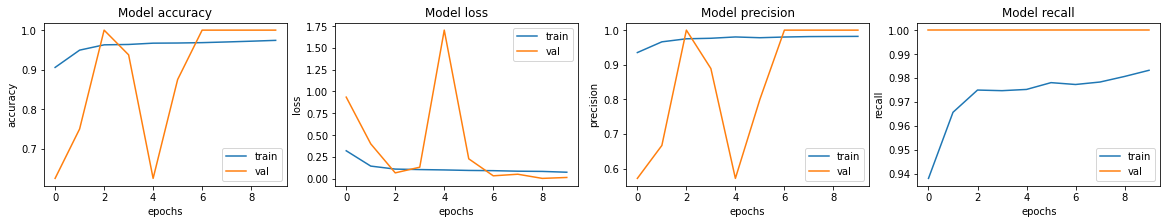

In [ ]:
plot_graphs(history, ['accuracy','loss','precision','recall'])

As we can see, the accuracy, loss, precision on validation set flucatated dramatically. 

# Model Evaluation

In [ ]:
loss, acc, prec, rec = model.evaluate(test_generator, verbose=2)

20/20 - 5s - loss: 0.2451 - accuracy: 0.9327 - precision: 0.9183 - recall: 0.9795


In [ ]:
y_pred = (model.predict(test_generator) > 0.5).astype("int32")

In [ ]:
def plot_confusion_matrix(actual_label, predicted_label):
  """
    Plot the confusion matrix
    
    Arguments:
    acutal_label -- the acutal label of the data
    predicted_label -- labes predicted by the model
  """
  cm = tf.math.confusion_matrix(actual_label,predicted_label) 
  plt.figure(figsize = (5,5))
  sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal','Pneumonia'] , yticklabels = ['Normal','Pneumonia'])

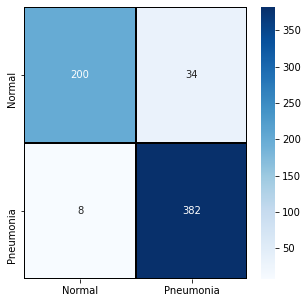

In [ ]:
plot_confusion_matrix(test_generator.classes, y_pred)

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.96      0.85      0.90       234
Pneumonia (Class 1)       0.92      0.98      0.95       390

           accuracy                           0.93       624
          macro avg       0.94      0.92      0.93       624
       weighted avg       0.93      0.93      0.93       624



Accuracy = (true_positives + true_negatives)/(total_examples) <br>
Precision = (true_positives)/(true_positives + false_positives) <br>
Recall = (true_positives)/(true_positives + false_negatives) <br>
F1 = 2 * (Precision*Recall)/(Precision + Recall) <br>
In general, this model shows a good performance, the Precision for Pheumonia & Normal are both high. However, the Recall for Noraml is low as the model misclassified 34 normal X-rays as Pneumonia. This could be due to the imbalance of Normal/Pneumonia examples in training set.

In [ ]:
pred = np.reshape(y_pred, (y_pred.shape[0],))
index = np.where(np.not_equal(test_generator.classes, pred))[0]
for idx in index:
  print("{} | Actual Label: {} | Predicted Label: {}".format(test_generator.filenames[idx], test_generator.classes[idx], pred[idx]))

NORMAL/IM-0073-0001.jpeg | Actual Label: 0 | Predicted Label: 1
NORMAL/IM-0075-0001.jpeg | Actual Label: 0 | Predicted Label: 1
NORMAL/IM-0110-0001.jpeg | Actual Label: 0 | Predicted Label: 1
NORMAL/NORMAL2-IM-0072-0001.jpeg | Actual Label: 0 | Predicted Label: 1
NORMAL/NORMAL2-IM-0105-0001.jpeg | Actual Label: 0 | Predicted Label: 1
NORMAL/NORMAL2-IM-0173-0001-0001.jpeg | Actual Label: 0 | Predicted Label: 1
NORMAL/NORMAL2-IM-0173-0001-0002.jpeg | Actual Label: 0 | Predicted Label: 1
NORMAL/NORMAL2-IM-0195-0001.jpeg | Actual Label: 0 | Predicted Label: 1
NORMAL/NORMAL2-IM-0196-0001.jpeg | Actual Label: 0 | Predicted Label: 1
NORMAL/NORMAL2-IM-0198-0001.jpeg | Actual Label: 0 | Predicted Label: 1
NORMAL/NORMAL2-IM-0199-0001.jpeg | Actual Label: 0 | Predicted Label: 1
NORMAL/NORMAL2-IM-0206-0001.jpeg | Actual Label: 0 | Predicted Label: 1
NORMAL/NORMAL2-IM-0210-0001.jpeg | Actual Label: 0 | Predicted Label: 1
NORMAL/NORMAL2-IM-0219-0001.jpeg | Actual Label: 0 | Predicted Label: 1
NORMAL

# Summary
1. Imbalanced data could favour the model to classify an example to majority label. 
2. With limited data, we could benefit from transfer learning to build a good model.

References:
1. https://keras.io/api/applications/
2. https://cs231n.github.io/transfer-learning/